# Regression Analysis

### Imports

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    'clustering', 'closeness', 'betweenness',
    'average_shortest_path_lenght', 'eigenvector', 'assortativity',
    'information_centrality',
    'approximate_current_flow_betweenness_centrality', 'shannon_entropy',
    'degree_variance'
]

In [2]:
dataset = pd.read_csv('../data/dataset.csv')

In [3]:
filtered_dataset = dataset[(dataset['initialization'] == 'direct')]
filtered_dataset.describe()

,clustering,closeness,betweenness,average_shortest_path_lenght,eigenvector,assortativity,information_centrality,approximate_current_flow_betweenness_centrality,shannon_entropy,degree_variance,consensus_time,opinion_change_frequency,groups
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.00000,558.000000
mean,0.134973,0.302541,1522.851944,4.044704,0.230008,-0.018908,0.003183,0.007993,2.980314,40.393910,8151.512204,1508.18724,2.326165
std,0.238953,0.101750,1151.472082,2.302944,0.173878,0.163531,0.000841,0.006720,1.210182,59.354528,16499.204832,2812.11660,1.638100
min,0.008343,0.096122,548.311000,2.095622,0.048632,-0.394020,0.001307,0.003230,0.377454,3.452053,14.380000,200.00000,0.000000
25%,0.023500,0.295687,1002.345000,3.003690,0.077912,-0.028069,0.002955,0.004963,2.621872,6.344289,489.670000,200.00000,1.000000
50%,0.026425,0.313753,1101.902500,3.202805,0.101251,-0.005222,0.003437,0.005224,3.645626,14.142136,623.300000,202.20000,2.000000
75%,0.032066,0.334649,1198.682000,3.396364,0.400087,0.117568,0.003652,0.005649,3.831956,32.907699,1357.125000,250.97500,4.000000
max,0.652846,0.478556,4797.811000,10.594622,0.621034,0.204217,0.004290,0.027219,4.027738,204.959142,72565.190000,9926.66000,5.000000


### Adjusted R2

In [168]:
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array, n: int, p: int):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

### Creating Scaler

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# dataset[FEATURES] = scaler.fit_transform(dataset[FEATURES])
# dataset[['consensus_time', 'opinion_change_frequency']] = scaler.fit_transform(dataset[['consensus_time', 'opinion_change_frequency']])

### Train Test Split

In [119]:
from sklearn.model_selection import train_test_split

# filtered_dataset.loc[:, FEATURES] = scaler.fit_transform(filtered_dataset[FEATURES])
# filtered_dataset.loc[:, 'opinion_change_frequency'] = scaler.fit_transform(np.array(filtered_dataset['opinion_change_frequency']).reshape(-1, 1))

y = filtered_dataset[CONSENSUS_TIME]
X = sm.add_constant(
   filtered_dataset[FEATURES]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, shuffle=True
)

# X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
# X_test[FEATURES] = scaler.transform(X_test[FEATURES])


## Linear

In [134]:
mod = sm.OLS(
    endog=y_train, 
    exog=X_train,
)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2507.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:54:45   Log-Likelihood:                -4084.8
No. Observations:                 446   AIC:                             8190.
Df Residuals:                     436   BIC:                             8231.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

> The smallest eigenvalue is 1.74e-29. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.

This happens because of the strong collinearity between some variables

In [137]:
y_pred = res.predict(X_test)

In [169]:
adjusted_r2_score(y_pred, y_test, len(y_pred), len(FEATURES))

0.9653368194240126

### Residuals

<Axes: ylabel='consensus_time'>

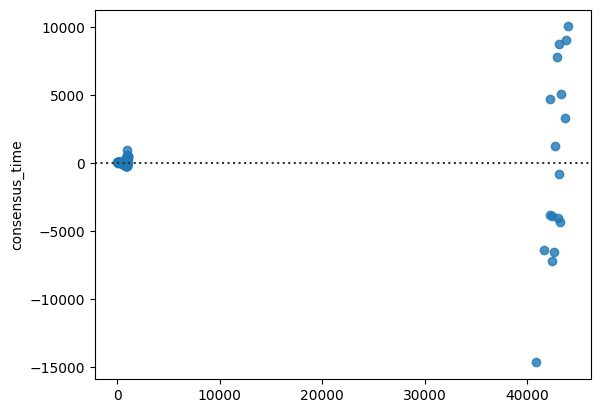

In [170]:
sns.residplot(x=y_pred, y=y_test)

## LASSO Regression
We intend to use Lasso for variable selection

In [172]:
from sklearn.linear_model import LassoCV

X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
X_test[FEATURES] = scaler.transform(X_test[FEATURES])

lasso_cv = LassoCV(cv=20, random_state=0).fit(X_train, y_train)

With fitted alpha, lets see statsmodels summary

In [215]:
mod = sm.OLS(
    endog=y_train, 
    exog=X_train['clustering'],
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=lasso_cv.alpha_,
    L1_wt=1,
    refit=True
)

In [216]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         consensus_time   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              1412.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):                   3.96e-140
Time:                        20:27:02   Log-Likelihood:                         -4701.1
No. Observations:                 446   AIC:                                      9404.
Df Residuals:                     445   BIC:                                      9408.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [176]:
LASSO_FEATURES = [
    'clustering',
    'closeness',
    'betweenness',
    'assortativity',
    'information_centrality',
    'shannon_entropy',
    'degree_variance'
]

In [224]:
y_pred = res.predict(X_test['clustering'])
adjusted_r2_score(y_pred, y_test, len(y_pred), 10)

0.6058252806400916

<Axes: ylabel='consensus_time'>

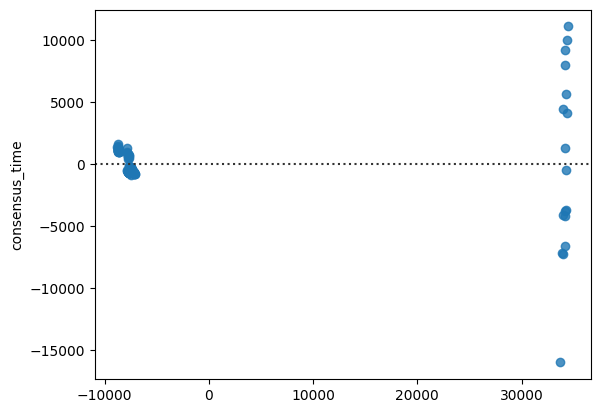

In [218]:
sns.residplot(x=y_pred, y=y_test)

## Poisson Regression

In [245]:
mod = sm.GLM(
    endog=y_train, 
    exog=sm.add_constant(X_train[LASSO_FEATURES]),
    family=sm.families.Poisson()
)
res = mod.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         consensus_time   No. Observations:                  446
Model:                            GLM   Df Residuals:                      438
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30403.
Date:                Thu, 22 Aug 2024   Deviance:                       56964.
Time:                        20:45:04   Pearson chi2:                 5.83e+04
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

In [246]:
y_pred = res.predict(sm.add_constant(X_test[LASSO_FEATURES]))

In [249]:
from sklearn.metrics import mean_tweedie_deviance
mean_tweedie_deviance(y_test, y_pred, power=1)

np.float64(94.92466472486434)

### Residual

<Axes: xlabel='consensus_time'>

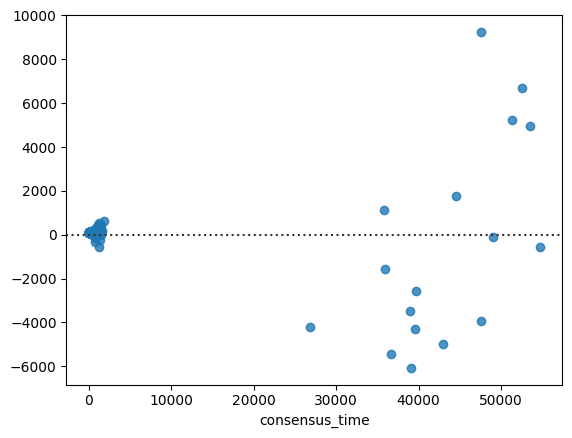

In [250]:
sns.residplot(x=y_test, y=y_test-y_pred)

<Axes: xlabel='consensus_time'>

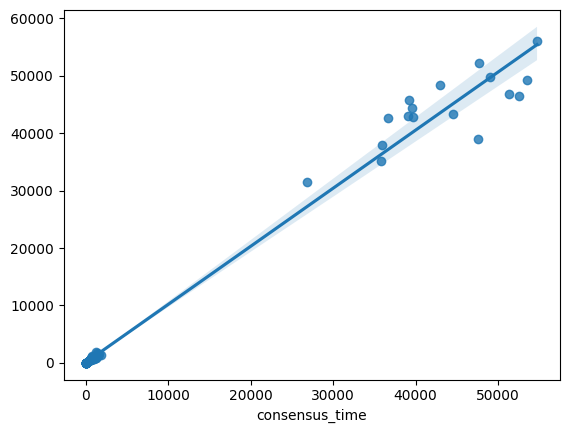

In [251]:
sns.regplot(x=y_test, y=y_pred)

<Axes: xlabel='clustering', ylabel='consensus_time'>

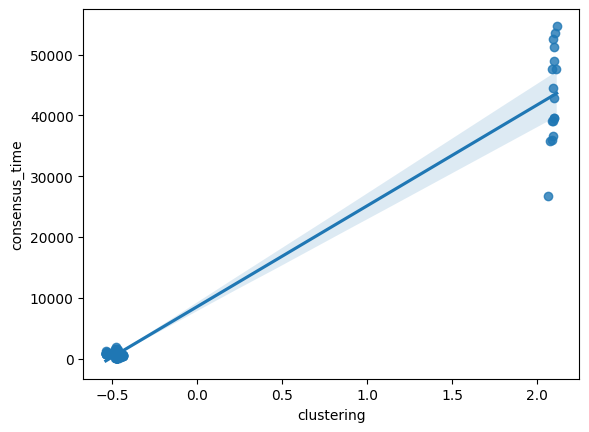

In [252]:
sns.regplot(x=X_test['clustering'], y=y_test)

In [253]:
adjusted_r2_score(y_pred, y_test, len(y_pred), len(LASSO_FEATURES))

0.9863364641124683